The assignment's leaning outcome 

What are orthophotos?

A definition of orthophoto (orthophotography or orthoimage) is an aerial photography or satellite image that is geometrically corrected from edge to edge. It means that the scale is uniformed and the photo or image follows a given map projection. Unlike an uncorrected aerial photography, an orthophoto can be use to measure true distance since it is an accurate representation of the earth's surface, having been adjusted for topographic relies, lens distortion, and camera tilt.(Mapasyst.extension.org, 2021) Therefore, "true orthophotos" means that an aerial photography or satellite image that has been corrected its topographic relies, lens distortion, and camera tilt.


When we consider an implementation of the adjustment to create orthophoto."True orthophotos" seems to have variations. For instance, Z-buffer based methods are more popular than indirect methods (used later), which is discussed in our lecture and instruction materials. Therefore, creation of orthophoto may needs have clear idea for its application. It can be guided with ISO standards, specifications, and recommendations to ensure the level of quality. For example, NLS provide a belief description of their Orthophotos such as pixel size, spatial representation, data contents and its quality information such as lineage and conformity. Detail of such descriptions relates to the ISO standards and specifications.(National Land Survey of Finalnd, 2021) other example for the recommendations can relates to Smith's publication that describes five recommendations for reviewing digital orthophoto imeagery(Smith, 1995);

* Sample points away from roads and location where DEM points will have been taken.

* Require that the DEM and the digital imagery be provided before the review process is started. It is often helpful to review the imagery with these point positioned on top of the imagery.

* Consider having the contractor deliver a point coverage for the centers of the original photography that can be positioned o top of the digital imagery.  This will allow the review to identify the photo from which the orthophoto was built.

* Where possible overlay the imagery with a linear coverage like a road or stream network from another map source to help look for spatial errors.

* Establish an accept/reject criteria before starting the review process.  Pieces of dirt and lint will occur.  Establishing ahead of time the maximum amount and size acceptable will facilitate the process.  This should be shared with the contractor.

In short, true orthophoto is geometrically corrected aerial photography or satellite image by applying certain algorithm in topographic relies, lens distortion, and camera tilt. That must have a certain level of confidence that tie to ISO standards, specifications, and recommendations.


Mapasyst.extension.org. 2021. What is an orthophoto? – Geospatial Technology. [online] Available at: <https://mapasyst.extension.org/what-is-an-orthophoto/> [Accessed 29 September 2021].

Smith, G.S., 1995, May. Digital orthophotography and GIS. In Proceedings of the 1995 ESRI User Conference (pp. 22-26).

Thrower, N.J. and Jensen, J.R., 1976. The orthophoto and orthophotomap: characteristics, development and application. The American Cartographer, 3(1), pp.39-56.


Short self-evaluation

It seemed to be difficult to understand the provided code for students who learned a programming in other languages. Other difficulty can be the gap of knowledge in Geoinformatic's specific terminology and techniques such as understanding the various coordination systems which used in image and data provided for creating an orthophoto. It took while to understand a reason of addition and subtraction in front of index i and j (code line[24]). It creates the output image that rotated regarding to the laser data values. Therefore, the north is in the top of image. 

Creating an orthophotos by translating Matlab code in python

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy
from sklearn.neighbors import KDTree
from tqdm.autonotebook import tqdm

<ipython-input-1-18a247596c9b>:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
%config InlineBackend.figure_format = "retina"

In [3]:
def read_laserdata(filename="laserdata.txt"):
    df = pd.read_csv(filename, sep=' ', header=None)
    laser_data = df.to_numpy()
    return laser_data


def read_image(filename="test_image_gray.tif"):
    image = plt.imread(filename)
    return image

In [4]:
def read_camera_orientation_info(filename="camera_orientation_info.txt"):

    with open(filename, 'r') as f:
        lines = f.read().splitlines()

    pp_x = float(lines[1])
    pp_y = float(lines[2])
    c = float(lines[4])

    x_0 = float(lines[9])
    y_0 = float(lines[10])
    z_0 = float(lines[11])

    r = np.zeros((3, 3))

    for i in range(3):
        str_row = lines[13 + i].split("\t")
        r[i] = [float(x) for x in str_row]

    return pp_x, pp_y, c, r, x_0, y_0, z_0

In [5]:
def d(x, x_i):

    try:
        X, Y = x
        X_i, Y_i = x_i
        return np.sqrt((X - X_i) ** 2 + (Y - Y_i) ** 2)
    except:
        print('was it testing with 1D?')
        return np.sqrt((x - x_i) ** 2)


def w(d_i, p=2):
    return 1 / d_i**p


def u(neighbours_u, neighbours_d):

    n = len(neighbours_d)

    weights = []
    for i in range(n):
        d_i = neighbours_d[i]
        weight_i = w(d_i)
        weights.append(weight_i)

        # print(f'weight {i+1}: {weight_i}')

    sum_weights = np.sum(weights)

    total = 0
    for i in range(n):
        u_i = neighbours_u[i]
        w_i = weights[i]
        to_add = w_i * u_i
        total += to_add

        # print(f'w{i + 1}u{i+1}: {to_add}')

    result = total / sum_weights
    return result

In [6]:
def collinearity_equations(x, y, z, c, x0, y0, z0, r):
        
    denom = r[2, 0]*(x-x0) + r[2, 1]*(y-y0) + r[2, 2]*(z-z0)
    x_cam = -c * (r[0, 0]*(x-x0) + r[0, 1]*(y-y0) + r[0, 2]*(z-z0)) / denom
    y_cam = -c * (r[1, 0]*(x-x0) + r[1, 1]*(y-y0) + r[1, 2]*(z-z0)) / denom
        
    return x_cam, y_cam

In [9]:
def camera_coordinates2image_coordinates(x_cam, y_cam, pp_x, pp_y):
    # -1: matlab/python conversion
    return x_cam + pp_x - 1, pp_y - y_cam - 1

In [10]:
def bilinear_interpolation(x_img, y_img, image):
    
    k = int(x_img)
    l = int(y_img)
    dx = x_img - k
    dy = y_img - l
    return (1-dx)*(1-dy)*image[l, k] + dx*(1-dy)*image[l, k+1] + (1-dx)*dy*image[l+1, k] + dx*dy*image[l+1, k+1]

In [11]:
grid_size = 0.2 

In [12]:
laser = read_laserdata()
laser_x = laser[:, 0]
laser_y = laser[:, 1]
laser_z = laser[:, 2]

In [13]:
pp_x, pp_y, c, r, x0, y0, z0 = read_camera_orientation_info()

In [14]:
image = read_image()

In [15]:
img_shape = image.shape
img_shape

(2028, 3037)

In [16]:
laser_x.min(), laser_x.max()

(6088.331, 6129.6)

In [17]:
laser_y.min(), laser_y.max()

(5226.271, 5276.468)

In [18]:
n_col = int(np.round((laser_x.max() - laser_x.min())/grid_size))
n_row = int(np.round((laser_y.max() - laser_y.min())/grid_size))

In [19]:
n_row, n_col

(251, 206)

In [21]:
orthophoto = np.zeros((n_row, n_col))

x_start = laser_x.min()
y_start = laser_y.min() + grid_size*n_row

In [22]:
laser_xy = np.vstack((laser_x, laser_y)).T
tree = KDTree(laser_xy)
dem = np.zeros((n_row, n_col))
n_comp = n_row*n_col

In [23]:
from math import floor, ceil

In [24]:
with tqdm(total=n_comp) as pb:

    for i in range(n_row):
    
        for j in range(n_col):
            
            x = x_start + j*grid_size
            y = y_start - i*grid_size

            dist, ind = tree.query(np.array([[x, y], ]), k=5)
            # ind/dist shape: 1 x k
            neighbours_u = laser_z[ind[0]]
            neighbours_d = dist[0]

            interpolated_height = u(neighbours_d=neighbours_d,
                                    neighbours_u=neighbours_u)
            dem[i, j] = interpolated_height
            
            # 3D point to image plane
            x_cam, y_cam = collinearity_equations(x, y, interpolated_height, c, x0, y0, z0, r)
            
            # from camera coordinate system into image coordinate system
            x_img, y_img = camera_coordinates2image_coordinates(x_cam, y_cam, pp_x, pp_y)
            # 'matlab' row and 'matlab' column!!
            row = int(y_img)
            column = int(x_img)
            
            # floor cannot lead to 0... therefore >1
            if row > 0 and column > 0 and row < img_shape[0] and column < img_shape[1]: 
                # selecting the best color value from original image using
                # bilinear interpolation
                
                # color1 = row,column; color2=row,column+1; color3=row+1,column; color4=row+1,column+1 
                interpolated_color = bilinear_interpolation(x_img, y_img, image)
                
                # setting interpolated color value to ortho image 
                orthophoto[i,j] = interpolated_color

            else:
                # if we are outside the image area, set color value zero
                orthophoto[i,j] = 0.0
                
            pb.update()

  0%|          | 0/51706 [00:00<?, ?it/s]

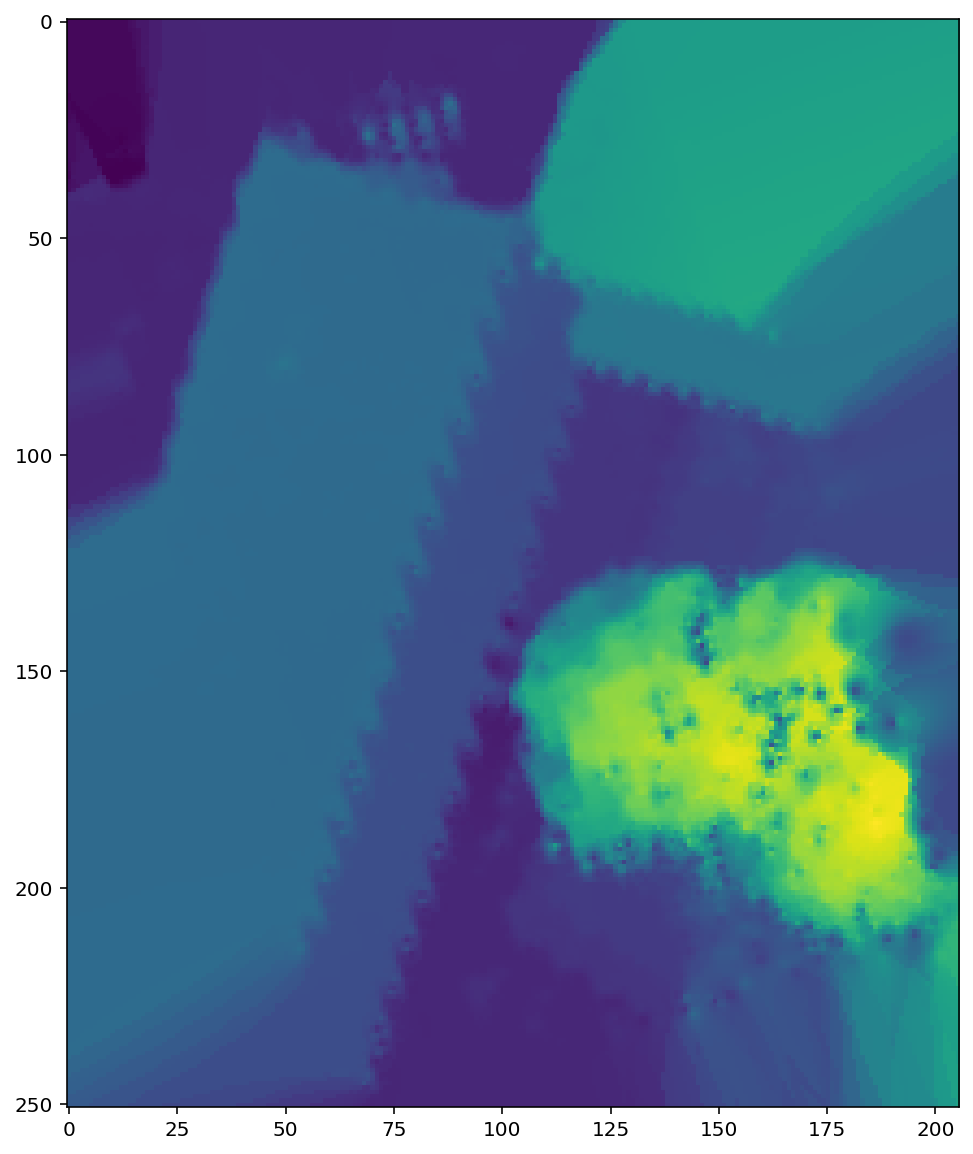

In [25]:
fig, ax = plt.subplots(figsize=(15, 10)) 
ax.imshow(dem)

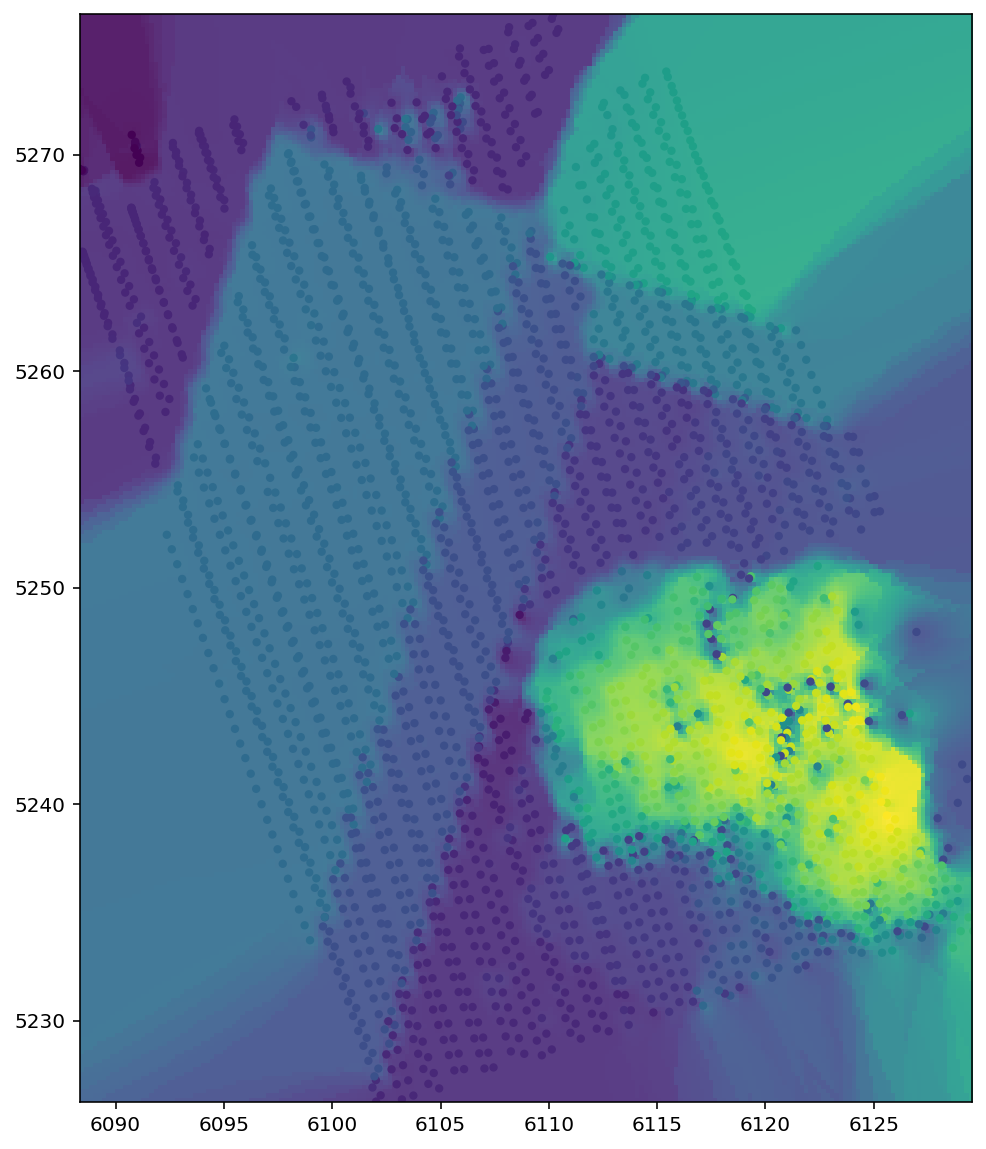

In [26]:
fig, ax = plt.subplots(figsize=(15, 10))

left = x_start
right = x_start + grid_size*n_col
bottom = y_start - grid_size*n_row
top = y_start

ax.imshow(dem, extent=(left, right, bottom, top), alpha=0.9)

ax.scatter(laser_x, laser_y, c=laser_z, s=10)

ax.set_xlim(left, right)

plt.show()

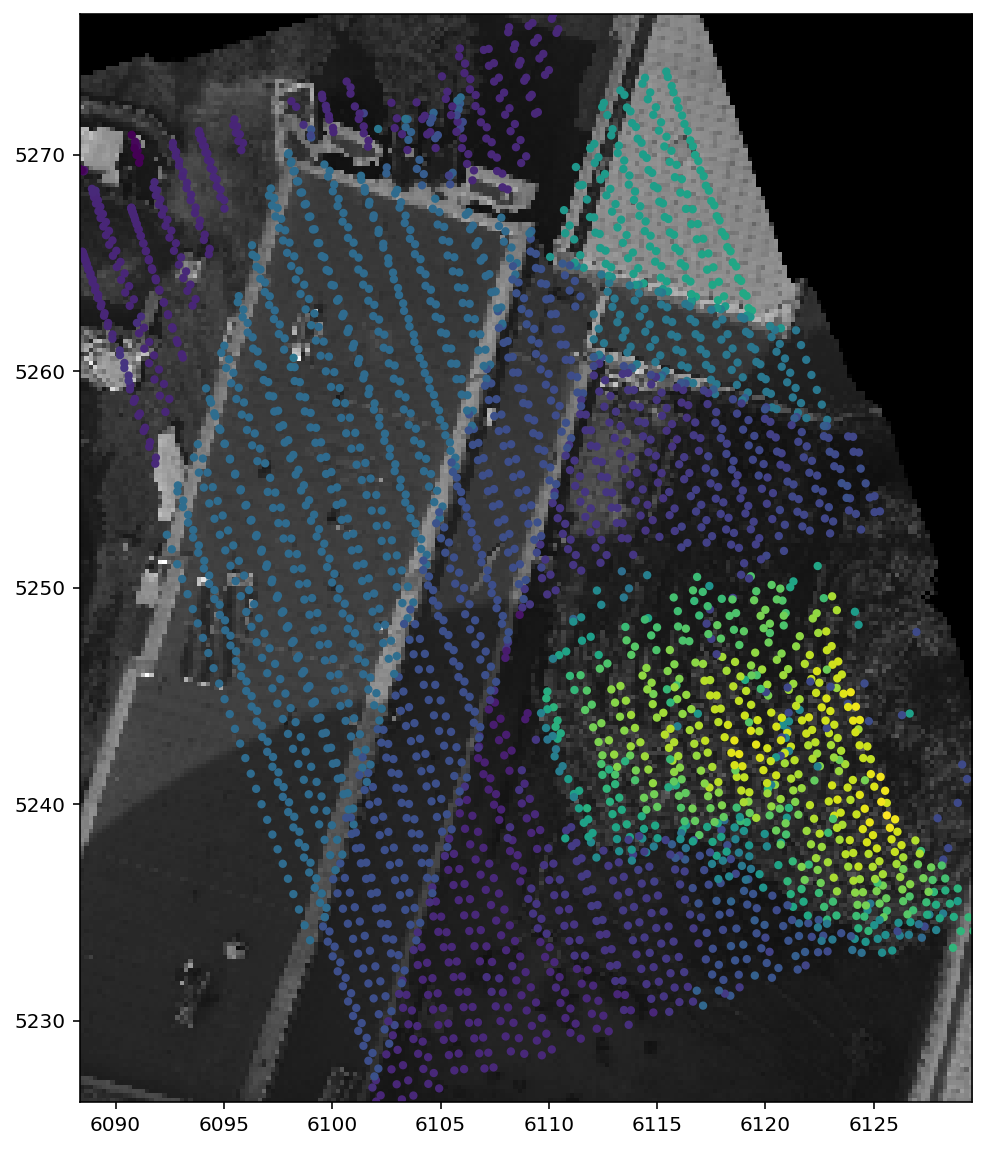

In [27]:
fig, ax = plt.subplots(figsize=(15, 10))

left = x_start
right = x_start + grid_size*n_col
bottom = y_start - grid_size*n_row
top = y_start

ax.imshow(orthophoto, extent=(left, right, bottom, top), cmap="gray")

ax.scatter(laser_x, laser_y, c=laser_z, s=10)

ax.set_xlim(left, right)

plt.show()

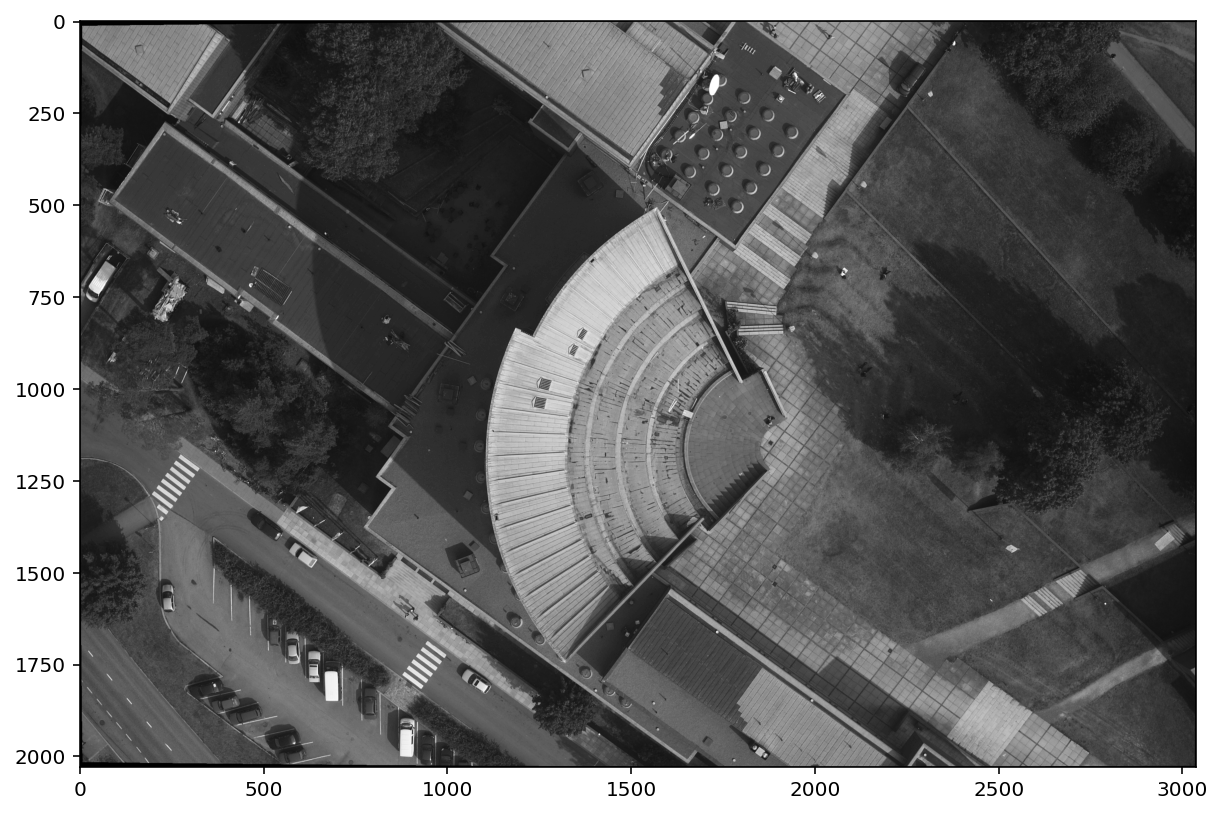

In [28]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.imshow(image, cmap="gray")

plt.show()

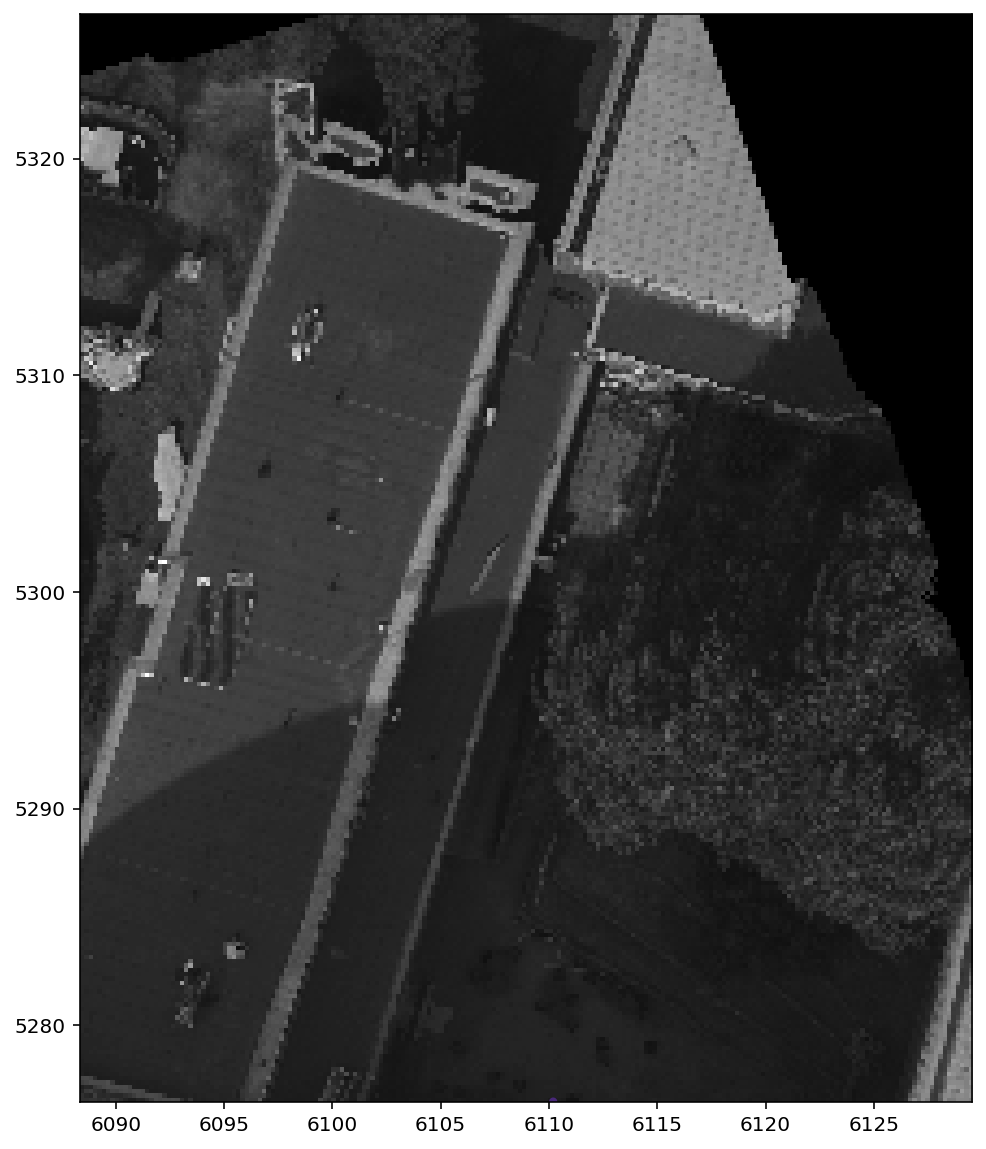

In [29]:
fig, ax = plt.subplots(figsize=(20, 10))

left = x_start
right = x_start + grid_size*n_col
top = y_start + grid_size*n_row
bottom = y_start

ax.scatter(laser_x, laser_y, c=laser_z, s=10)

ax.imshow(orthophoto, extent=(left, right, bottom, top), cmap="gray")
# ax.scatter(laser_x, laser_y, c=laser_z, s=10)

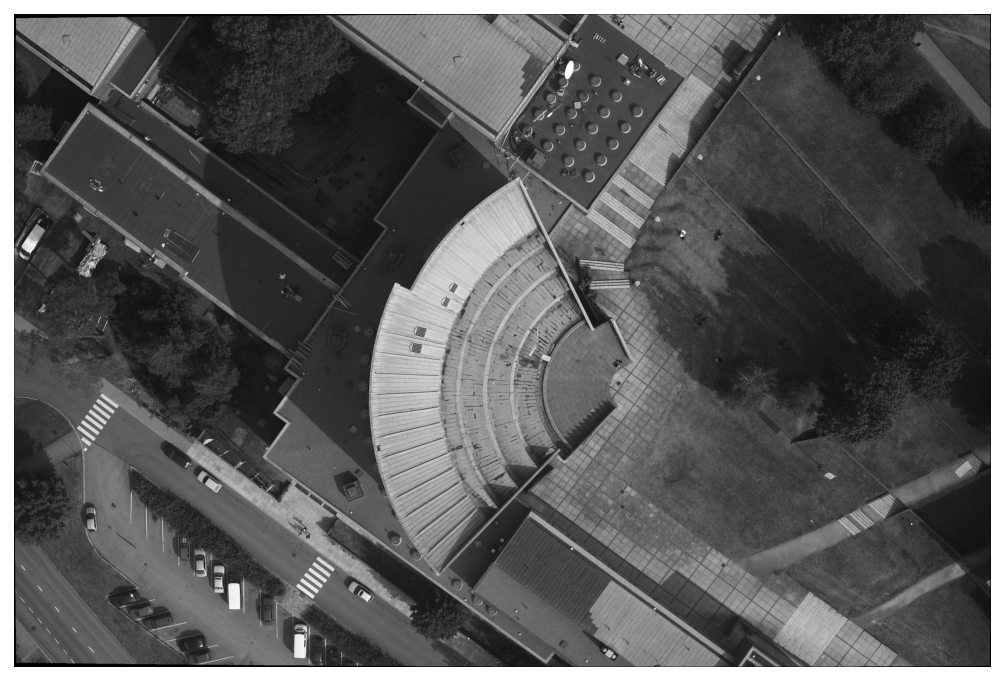

In [30]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.imshow(image, cmap='gray', vmin=0, vmax=255)
ax.set_axis_off()

plt.show()

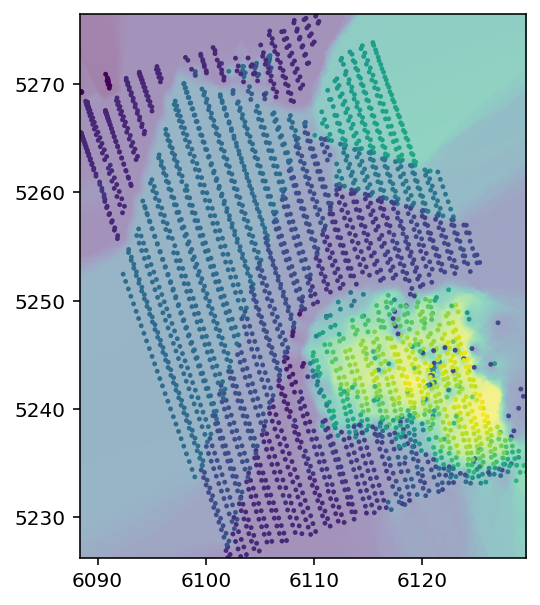

In [31]:
fig, ax = plt.subplots(figsize=(10, 5))

left = x_start
right = x_start + grid_size*n_col
bottom = y_start - grid_size*n_row
top = y_start

ax.imshow(dem, extent=(left, right, bottom, top), alpha=0.5)

ax.scatter(laser_x, laser_y, c=laser_z, s=2)

ax.set_xlim(left, right);

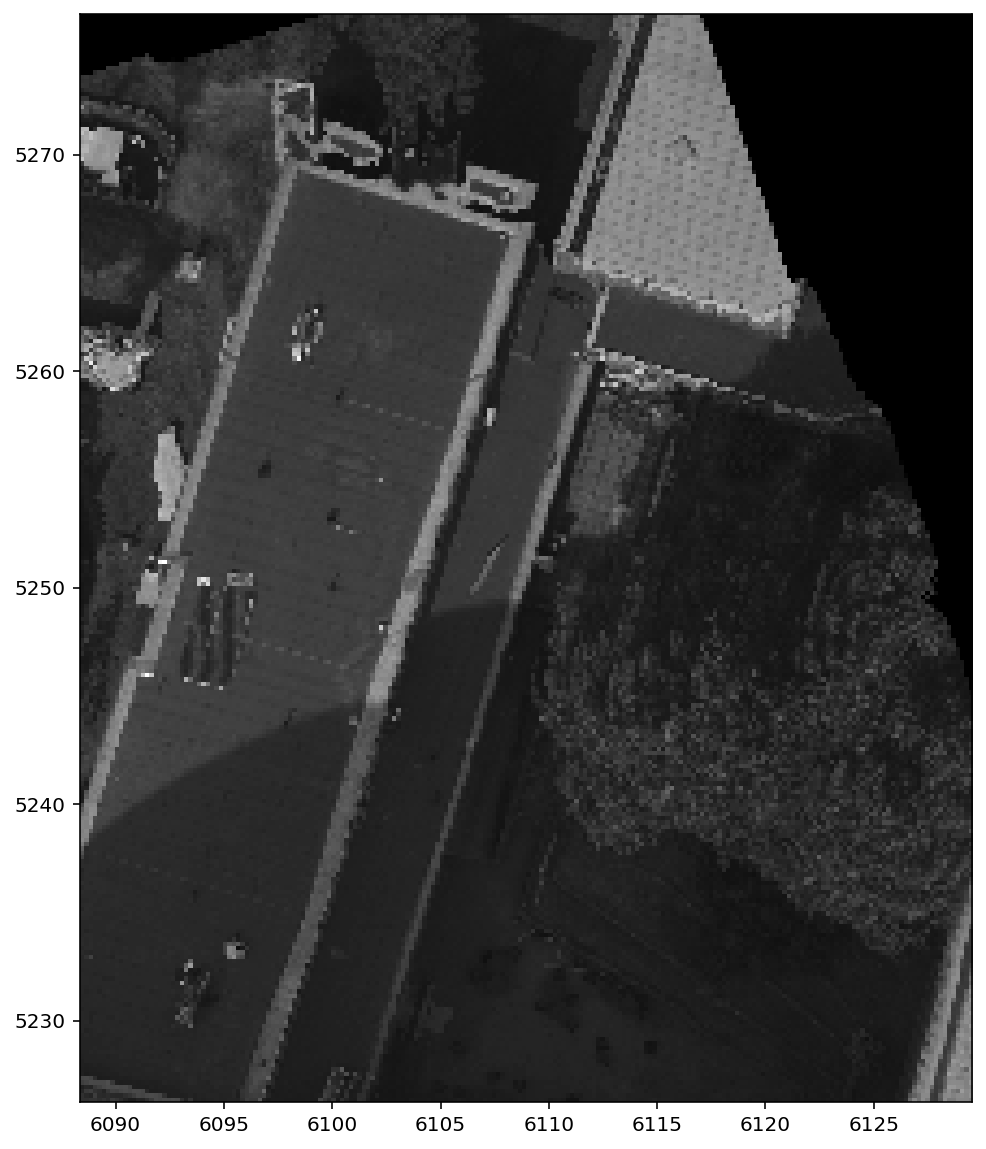

In [33]:
fig, ax = plt.subplots(figsize=(20, 10))

left = x_start
right = x_start + grid_size*n_col
bottom = y_start - grid_size*n_row
top = y_start

ax.imshow(orthophoto, extent=(left, right, bottom, top), cmap="gray")

plt.show()